In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

2024-04-24 20:36:51.827064: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 20:36:52.784999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 20:36:52.785045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 20:36:52.871826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 20:36:53.185404: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import numpy as np
import random

def set_seeds(seed_value):
    # TensorFlow
    tf.random.set_seed(seed_value)

    # NumPy
    np.random.seed(seed_value)

    # Python built-in random module
    random.seed(seed_value)

# Set the seed
seed_value = 42  # You can use any integer value
set_seeds(seed_value)

In [3]:
data_dir = Path('/home/manusharma/GAN_medical_images/chest_xray')

Path to train directory (Fancy pathlib...no more os.path!!)

In [4]:
train_dir = data_dir / 'train'

Path to validation directory

In [5]:
val_dir = data_dir / 'val'

Path to test directory

In [6]:
test_dir = data_dir / 'test'

In [7]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

Get the list of all the images

In [8]:
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

An empty list. We will insert the data into this list in (img_path, label) format

In [9]:
train_data = []

Go through all the normal cases. The label for these cases will be 0

In [10]:
for img in normal_cases:
    train_data.append((img,0))

Go through all the pneumonia cases. The label for these cases will be 1

In [11]:
for img in pneumonia_cases:
    train_data.append((img, 1))

Get a pandas dataframe from the data we have in our list 

In [12]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

Shuffle the data 

In [13]:
train_data = train_data.sample(frac=1.).reset_index(drop=True)

How the dataframe looks like?

In [14]:
train_data.head()

image  label
0  /home/manusharma/GAN_medical_images/chest_xray...      1
1  /home/manusharma/GAN_medical_images/chest_xray...      0
2  /home/manusharma/GAN_medical_images/chest_xray...      1
3  /home/manusharma/GAN_medical_images/chest_xray...      1
4  /home/manusharma/GAN_medical_images/chest_xray...      1

In [15]:
cases_count = train_data['label'].value_counts()
print(cases_count)

label
1    3875
0    1341
Name: count, dtype: int64


Plot the results 

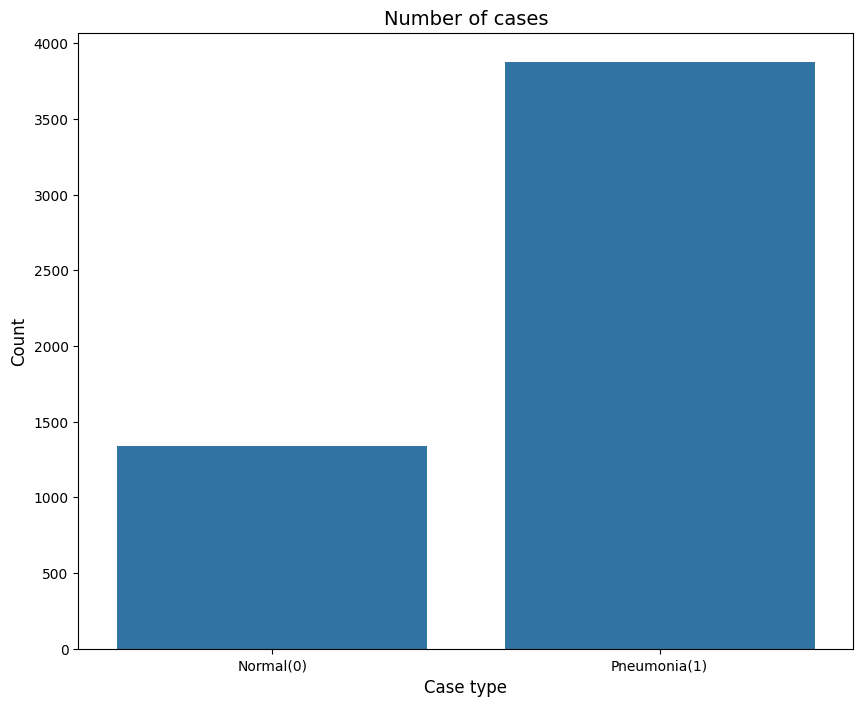

In [16]:
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [17]:
trainX = np.load('/home/manusharma/GAN_medical_images/trainX.npy')
trainY = np.load('/home/manusharma/GAN_medical_images/trainY.npy')

print(trainX.shape)
print(trainY.shape)

(4987, 256, 256, 1)
(4987,)


In [18]:
trainX = (trainX - 127.5) / 127.5

In [19]:
print(trainX)

[[[[-0.12941177]
   [ 0.01176471]
   [-0.01960784]
   ...
   [-0.75686276]
   [-0.70980394]
   [-0.8039216 ]]

  [[-0.27058825]
   [-0.05098039]
   [-0.03529412]
   ...
   [-0.7490196 ]
   [-0.7411765 ]
   [-0.7882353 ]]

  [[-0.24705882]
   [-0.12941177]
   [-0.07450981]
   ...
   [-0.7411765 ]
   [-0.7254902 ]
   [-0.8117647 ]]

  ...

  [[-0.7019608 ]
   [-0.7019608 ]
   [-0.7254902 ]
   ...
   [-0.77254903]
   [-0.7411765 ]
   [-0.7254902 ]]

  [[ 0.92941177]
   [-0.54509807]
   [-0.70980394]
   ...
   [-0.77254903]
   [-0.6       ]
   [ 0.8980392 ]]

  [[-0.7882353 ]
   [-0.73333335]
   [-0.70980394]
   ...
   [-0.75686276]
   [-0.7647059 ]
   [-0.79607844]]]


 [[[-1.        ]
   [-0.9843137 ]
   [-0.9529412 ]
   ...
   [-0.7176471 ]
   [-0.7490196 ]
   [-0.75686276]]

  [[-1.        ]
   [-0.9843137 ]
   [-0.9843137 ]
   ...
   [-0.70980394]
   [-0.7411765 ]
   [-0.77254903]]

  [[-1.        ]
   [-0.9843137 ]
   [-0.9529412 ]
   ...
   [-0.73333335]
   [-0.7647059 ]
   [-0.7725

In [20]:
BUFFER_SIZE = 4987
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-04-24 20:37:05.183959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 20:37:06.040087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 20:37:06.040166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 20:37:06.042596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 20:37:06.042691: I external/local_xla/xla/stream_executor

2024-04-24 20:37:11.035114: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110912 bytes after encountering the first element of size 67110912 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


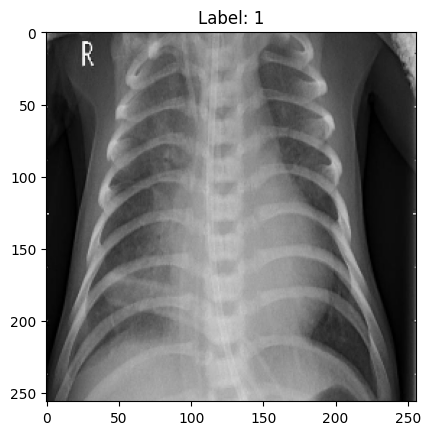

In [21]:
for img, label in train_dataset.take(1):
    
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title('Label: %i' % label[0].numpy())
    plt.show()

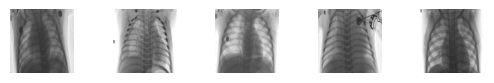

In [22]:
for i in range(5):
   # define subplot
   plt.subplot(5,5, 1 + i)
   # turn off axis
   plt.axis('off')
   # plot raw pixel data
   plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [23]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [24]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

In [25]:
def genG_model(latent_dim ,num_classes):
    # Define input layers
    
    input_label = Input(shape=(1,))
    
    # Embedding layer for labels
    label_embedding = Embedding(num_classes, 50)(input_label)
    label_embedding = Dense(64)(label_embedding)
    label_embedding = Reshape((8,8,1))(label_embedding)
    in_lat = Input(shape=(latent_dim,))

    # Generator layers
    gen = Dense(8*8*256, use_bias=False)(in_lat)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    gen = Reshape((8, 8, 256))(gen)
    
    # Concatenate noise and label embeddings
    combined_input = Concatenate()([gen, label_embedding])
    
    # Generator architecture
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(combined_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    
    
    # Define the generator model
    gen_model = Model([in_lat, input_label], x)
    
    return gen_model

2024-04-24 20:37:12.894181: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-24 20:37:13.624617: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


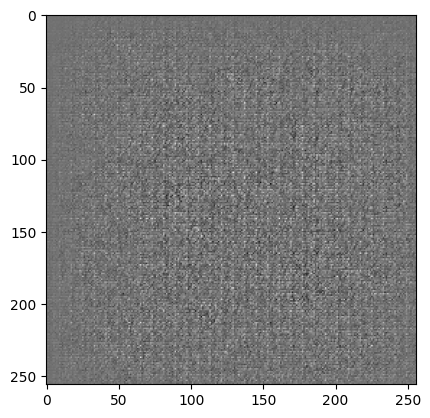

In [26]:
genG = genG_model(100, num_classes=2)
noise = tf.random.normal([1, 100]) #latent space #tensor of shape 1,100 is created with random values derived from normal distribution
label = tf.constant([[0]])
generated_image = genG([noise, label], training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray') 

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def make_discriminator_model(in_shape=(256, 256, 1), num_classes=2):
    # Define input layers for images and labels
    input_label = Input(shape=(1,))
    
    # Embedding layer for labels
    label_embedding = Embedding(num_classes, 50)(input_label)
    n_nodes = in_shape[0] * in_shape[1]
    label_embedding = Dense(n_nodes)(label_embedding)
    # Reshape label embedding to match image size
    label_embedding = Reshape((256, 256, 1))(label_embedding)
    in_image = Input(shape=in_shape)
    
    # Concatenate image and label embeddings
    combined_input = Concatenate()([in_image, label_embedding])
    
    # Discriminator layers
    x = Conv2D(8, (5, 5), strides=(2, 2), padding='same', input_shape=(256, 256, 2))(combined_input)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(16, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
  
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Define the model with input image and label and output discriminator prediction
    disc_model = Model([in_image, input_label], output)  # Return both output and features
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    disc_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return disc_model

In [28]:
discriM = make_discriminator_model((256,256,1),num_classes=2)
label = np.array([[0]])
decision = discriM([generated_image, label])
print(decision)

tf.Tensor([[0.49998856]], shape=(1, 1), dtype=float32)


In [29]:
def load_real_samples():
    return [trainX, trainY]

%%

In [30]:
def generate_real_samples(dataset, n_batch):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_batch) 
    X, labels = images[ix], labels[ix]
    y = np.ones((n_batch, 1))
    return [X, labels], y

In [31]:
def generated_latent_points(latent_dim, n_batch):
    x_input = np.random.randn(latent_dim * n_batch)
    z_input = x_input.reshape(n_batch, latent_dim)
    labels = np.random.randint(0, 2, n_batch)
    return [z_input, labels]

In [32]:
def generate_fake_samples(generator,latent_dim, n_batch):
    z_input, labels_input = generated_latent_points(latent_dim, n_batch)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_batch, 1))
    return [images, labels_input], y

In [33]:
def save_generated_images(generator, epoch, latent_dim, num_examples_to_generate, output_dir='generated_images', prefix='image'):
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    for i in range(num_examples_to_generate):
        [z_input, labels_input] = generated_latent_points(latent_dim, num_examples_to_generate)
        generated_images = generator.predict([z_input, labels_input])
        plt.imshow(generated_images[0, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.savefig(f'{output_dir}/{prefix}_epoch_{epoch}_image_{i}.png')
        plt.close()

In [34]:
# for i in range(num_examples_to_generate):
#     [z_input, labels_input] = generated_latent_points(latent_dim, num_examples_to_generate)
#     generated_images = generator.predict([z_input, labels_input])
#     plt.imshow(generated_images[0, :, :, 0], cmap='gray')
#     plt.axis('off')
#     plt.savefig(f'{output_dir}/{prefix}_epoch_{epoch}_image_{i}.png')
#     plt.close()

In [35]:
def feature_matching_loss(real_features, generated_features):
    return tf.reduce_mean(tf.abs(tf.reduce_mean(real_features, axis=0) - tf.reduce_mean(generated_features, axis=0)))

In [36]:
def build_feature_extractor(discriminator):
    model = Model(inputs=discriminator.input, outputs=discriminator.layers[-2].output)
    return model

In [37]:
feature_extractor = build_feature_extractor(discriM)

In [38]:
def gan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [39]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batches=256):
    batch_per_epoch = int(dataset[0].shape[0] / n_batches)
    half_batch = int(batch_per_epoch / 2)    
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # Generate real samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Train discriminator on real samples
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # Generate fake samples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator on fake samples
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            # Generate latent points and labels for the generator
            [z_input, labels_input], y_gan = generated_latent_points(latent_dim, n_batches), np.ones((n_batches, 1))
            # Train the GAN (generator) model
     
            gan_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

        # Print epoch-wise loss
        print('Epoch: %d, Discriminator Loss Real: %.3f, Discriminator Loss Fake: %.3f, GAN Loss: %.3f' % 
              (i+1, d_loss1, d_loss2, gan_loss))
        save_generated_images(g_model, i, latent_dim, 1)
        # Generate and display a sample of generated images
        
    
    # Save the trained generator model
    g_model.save('cgan_generator1.h5')
    d_model.save('cgan_discriminator1.h5')
    gan_model.save('cgan_gan1.h5')


2024-04-24 20:37:20.471297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 20:37:24.212938: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9644e74710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 20:37:24.212994: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-04-24 20:37:24.244979: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713971244.375586   28640 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 20ms/step
Epoch: 1, Discriminator Loss Real: 0.009, Discriminator Loss Fake: 0.535, GAN Loss: 0.000
8/8 [==============================] - 1s 4ms/step


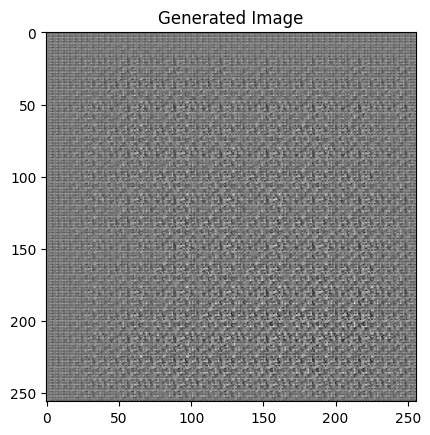

1/1 [==============================] - 0s 18ms/step
Epoch: 2, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.004, GAN Loss: 0.000
8/8 [==============================] - 0s 5ms/step


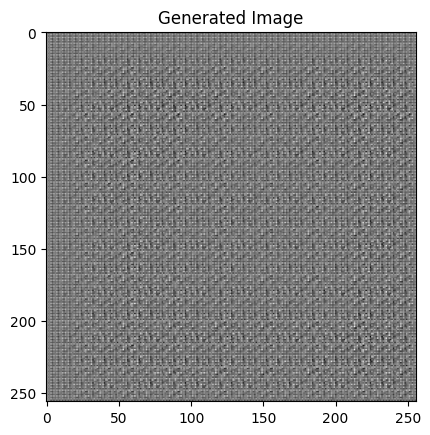

1/1 [==============================] - 0s 17ms/step
Epoch: 3, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.001, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


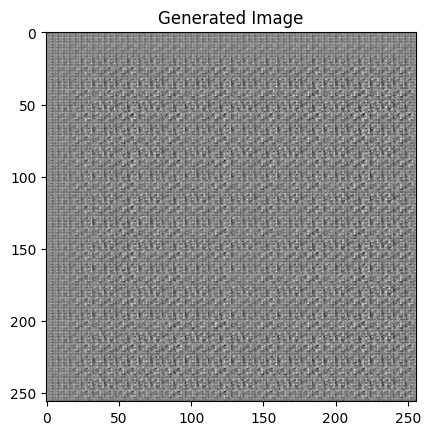

1/1 [==============================] - 0s 18ms/step
Epoch: 4, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.001, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


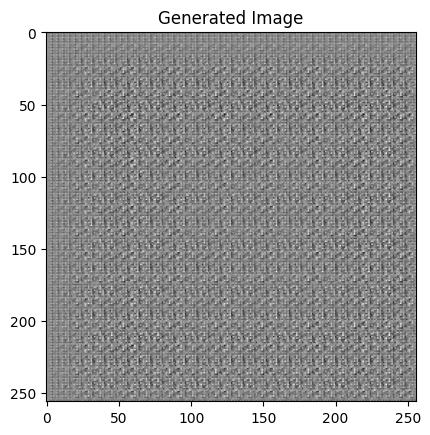

1/1 [==============================] - 0s 17ms/step
Epoch: 5, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 5ms/step


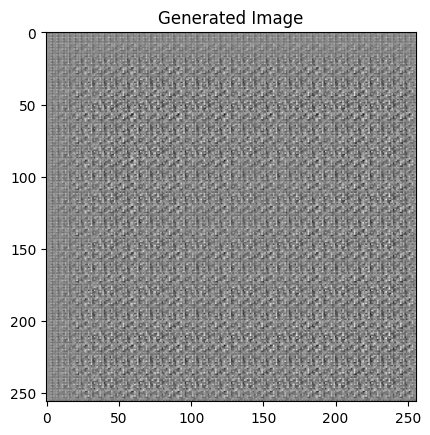

1/1 [==============================] - 0s 20ms/step
Epoch: 6, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


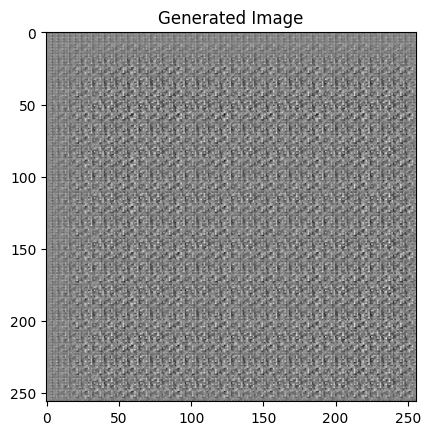

1/1 [==============================] - 0s 21ms/step
Epoch: 7, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


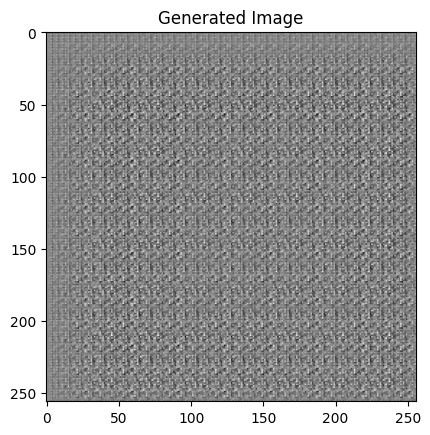

1/1 [==============================] - 0s 30ms/step
Epoch: 8, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


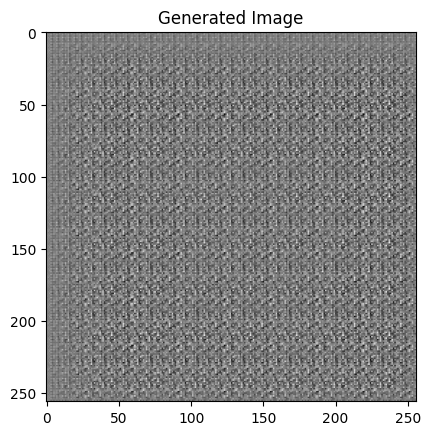

1/1 [==============================] - 0s 18ms/step
Epoch: 9, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 5ms/step


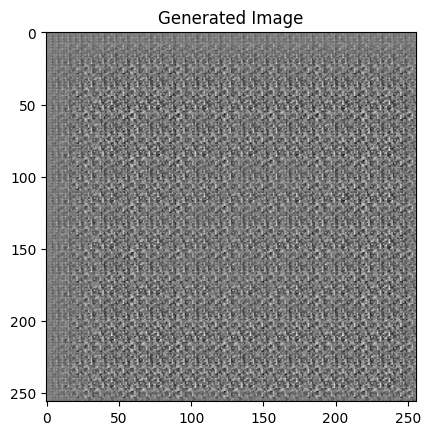

1/1 [==============================] - 0s 20ms/step
Epoch: 10, Discriminator Loss Real: 0.000, Discriminator Loss Fake: 0.000, GAN Loss: 0.000
8/8 [==============================] - 0s 4ms/step


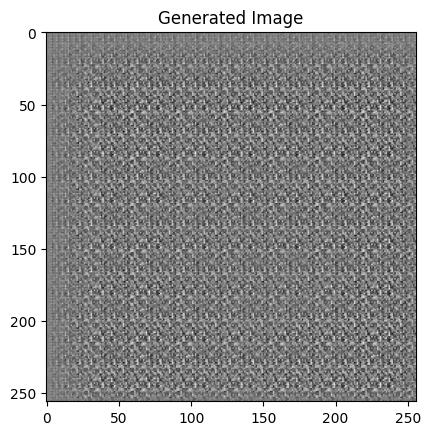

1/1 [==============================] - 0s 18ms/step
Epoch: 11, Discriminator Loss Real: 2.106, Discriminator Loss Fake: 0.185, GAN Loss: 0.514
8/8 [==============================] - 0s 5ms/step


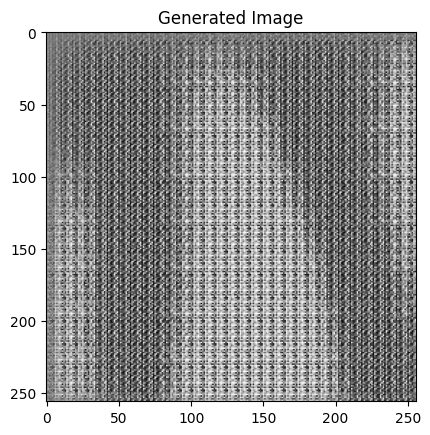

1/1 [==============================] - 0s 19ms/step
Epoch: 12, Discriminator Loss Real: 0.441, Discriminator Loss Fake: 0.099, GAN Loss: 0.191
8/8 [==============================] - 0s 4ms/step


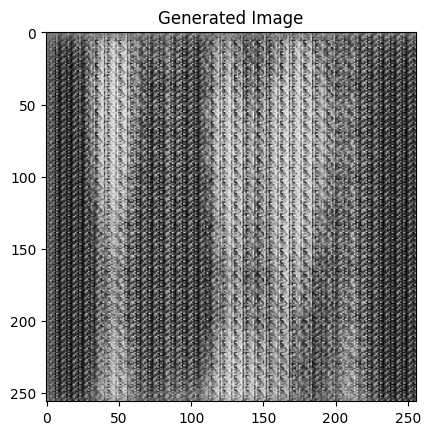

1/1 [==============================] - 0s 17ms/step


In [40]:
latent_dim = 100
# create the discriminator
d_model = make_discriminator_model()
# create the generator
g_model = genG_model(latent_dim, num_classes=2)
# create the gan
# load image data
dataset = load_real_samples()
gan_model = gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
import imageio
import os

# Directory containing the images
image_dir = '/home/manusharma/GAN_medical_images/generated_images'

# List all image files in the directory
image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])

# Create GIF file path
gif_file = 'output.gif'

# Create the GIF
with imageio.get_writer(gif_file, mode='I') as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f'GIF created: {gif_file}')